# Akıllı Mama Kabından Alınan Veri İle Mama Bitiş Süresi Tahmini

Bu notdefterinde Akıllı Mama kabına (Arduino) bağlı sensörlerden alınan veri yardımıyla mamanın bitmesine kalan süre tahmin edilecektir.

**ÖNEMLİ NOT :** Elimizdeki veri çok kısa bir zamanda toplantığı için üretimde bu verinin kullanılması söz konusu değildir. Şuan bu verideki eğilime göre oluşturulmuş sahte veri ile eğitilen model deploy edilmiştir. O modeli incelemek için [FoodRemainingTime](https://github.com/Dirty-Paws/AI/tree/main/FoodRemainingTime) klasörüne göz atabilirsiniz. Uygulama üretime geçtiğinde elde edilecek veri ile makine öğrenmesi modeli uygulama içerisinde aktif hale getirilecektir.

Gerekli Kütüphanelerin yüklenmesiyle başlayalım

In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# 1. İlk Bakış ve Önişleme

In [275]:
# Veriyi data isminde bir pandas DataFrame olarak yükleyelim
data = pd.read_csv("ArduinoSon.csv", header=None)

# İlk 20 kolona göz atalım
data.head(20)

,0
0,[2020-10-18 20:48:26.302]
1,[2020-10-18 20:48:26.302] Suyun Seviyesi:543
2,[2020-10-18 20:48:26.302] 28.84 celsius
3,[2020-10-18 20:48:26.302] 60cm'den daha uzak
4,[2020-10-18 20:48:26.302] Isik seviyesi:87
5,[2020-10-18 20:48:26.302]
6,[2020-10-18 20:48:26.302] Suyun Seviyesi:543
7,[2020-10-18 20:48:26.302] 40.57 celsius
8,[2020-10-18 20:48:26.302] 60cm'den daha uzak
9,[2020-10-18 20:48:26.302] Isik seviyesi:87


Elimizdeki veriyi uygun formatta bir tablo verisi haline getirmemiz gerekiyor. Şuan halihazırda bulunan verisetinde tek kolonda Tarih/Saat, Sıcaklık Sensörü, Ultrasonik Sensör, Işık Seviyesi, Su seviyesi verileri bulunmakta. Verileri uygun formata getirmek için bir fonksiyon yazalım.

In [276]:
# Verileri tutacak bir dictionary oluşturalım
dictionary={
    "DateTime":[],
    "IsFoodFinished":[],
    "WaterLevel":[],
    "LightLevel":[],
    "Temperature":[],
    "UltraLevel":[]
}

# Bütün satırlara teker teker bakacağız
count = 0
for index, row in data.iterrows():
        
    if count%5==0:
        match = re.search(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}', row[0])
        date = datetime.strptime(match.group(), '%Y-%m-%d %H:%M:%S')
        dictionary["DateTime"].append(date)
    
    # Su seviyesini kaydedelim
    match = re.search(r'Suyun Seviyesi:\s*([^\n]+)', row[0])
    if match:
        dictionary["WaterLevel"].append(int(match.group(1)))
        count +=1
        continue
    
    # Işık Seviyesini kaydedelim
    match = re.search(r'Isik seviyesi:\s*([^\n]+)', row[0])
    if match:
        dictionary["LightLevel"].append(int(match.group(1)))
        count +=1
        continue
        
    # Mama bitip bitmeme durumunu kontrol edelim
    match = re.search(r'Mama bitti.', row[0])
    if match:
        dictionary["IsFoodFinished"].append(1)
        count +=1
        continue
    elif len(row[0]) in range(25,27):
        dictionary["IsFoodFinished"].append(0)
        count +=1
        continue
        
    # Sıcaklık seviyesini kaydedelim
    match = re.search(r'\d+\.\d+\scelsius', row[0])
    if match:
        dictionary["Temperature"].append(float(match.group(0).split()[0]))
        count +=1
        continue
    
    # Mesafe verisini kaydedelim
    match = re.search(r'[0-9]{1,4}cm', row[0])
    if match:
        dictionary["UltraLevel"].append(int(match.group(0).split("cm")[0]))
        count +=1
        continue

Verimizi tablo haline getirdik. Artık pandas DataFrame olarak inceleyebiliriz

In [277]:
# Veriyi pandas DataFrame haline getirelim
data = pd.DataFrame.from_dict(dictionary)

# İlk 5 kolona göz atalım
display(data.head())

# Info
print(data.info())

# Özet istatistikler
display(data.describe())

,DateTime,IsFoodFinished,WaterLevel,LightLevel,Temperature,UltraLevel
0,2020-10-18 20:48:26,0,543,87,28.84,60
1,2020-10-18 20:48:26,0,543,87,40.57,60
2,2020-10-18 20:48:26,0,542,75,18.08,60
3,2020-10-18 20:48:26,0,544,91,34.70,60
4,2020-10-18 20:48:26,0,543,78,46.92,60


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DateTime        178 non-null    datetime64[ns]
 1   IsFoodFinished  178 non-null    int64         
 2   WaterLevel      178 non-null    int64         
 3   LightLevel      178 non-null    int64         
 4   Temperature     178 non-null    float64       
 5   UltraLevel      178 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 8.5 KB
None


,IsFoodFinished,WaterLevel,LightLevel,Temperature,UltraLevel
count,178.000000,178.000000,178.000000,178.000000,178.0
mean,0.213483,348.438202,198.022472,28.176292,60.0
std,0.410922,234.522520,231.022951,10.434949,0.0
min,0.000000,24.000000,59.000000,13.200000,60.0
25%,0.000000,88.000000,71.000000,23.950000,60.0
50%,0.000000,534.500000,75.000000,24.930000,60.0
75%,0.000000,548.750000,90.000000,31.280000,60.0
max,1.000000,672.000000,643.000000,56.210000,60.0


Veriyi görselleştirelim

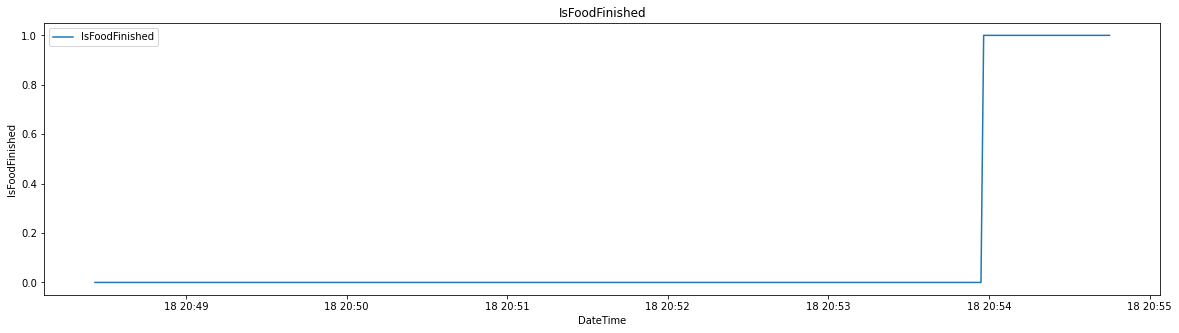

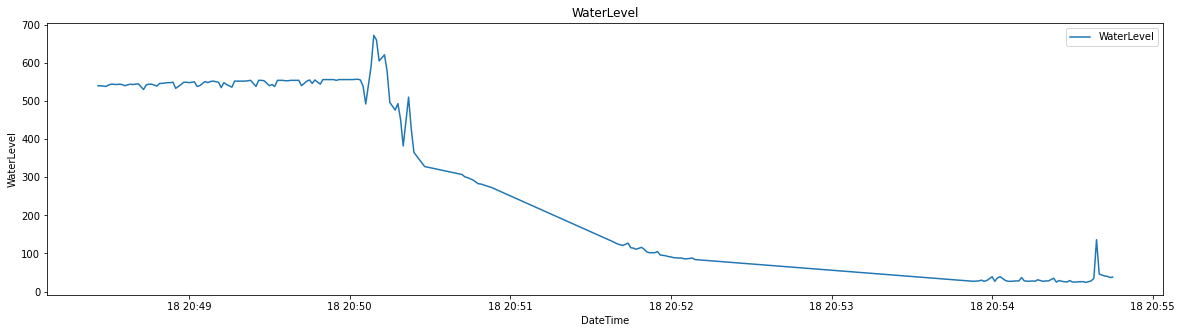

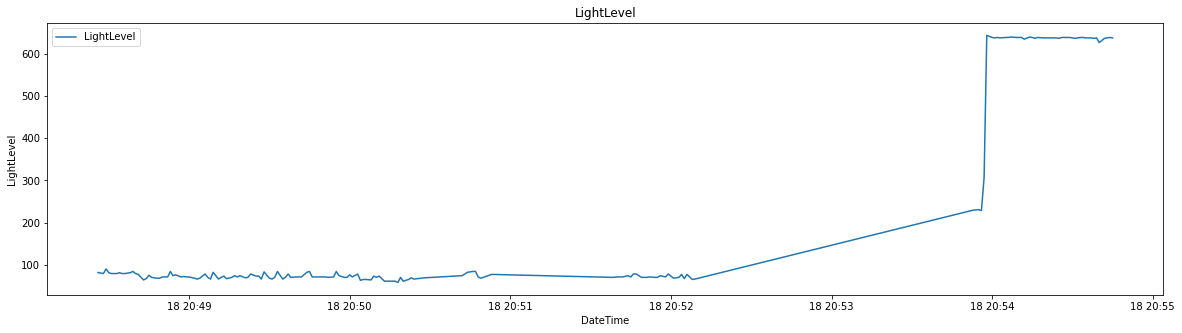

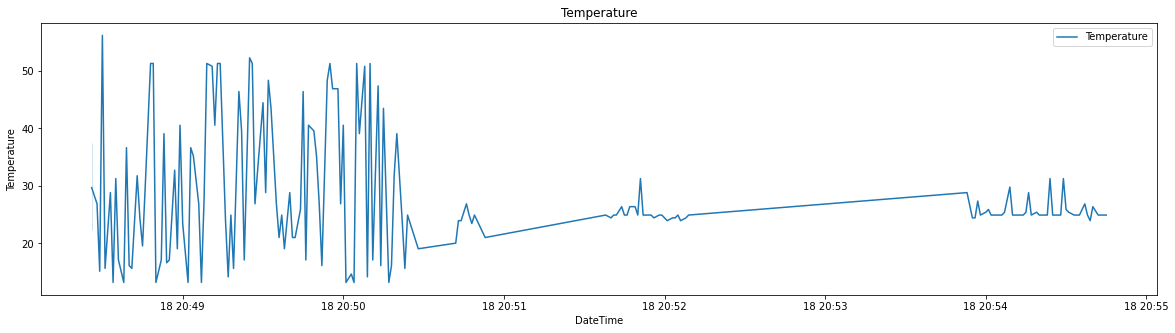

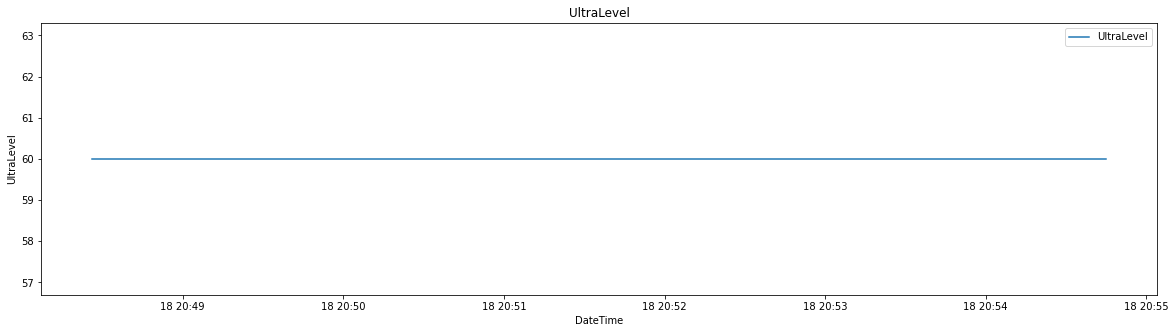

In [278]:
for column_name in data.columns[1:]:
    plt.figure(figsize = (20, 5), facecolor = None)
    plt.title(column_name)
    sns.lineplot(x="DateTime", y=column_name, data=data, label=str(column_name))
    plt.show()

Elimizdeki veri çok kısa bir zamanda toplandığı için üretimde kullanılabilecek durumda değil biz yine de modelimizi hazırlayacağız ve şimdilik üretim kısmında bu eğilime göre yarattığımız rastgele veriyi kullanacağız

# 2. Öznitelik Çıkarımı

Elimizdeki verisetine göre mamanın bitmesine kaç saat olduğunu bağımlı değişkenimiz olmak üzere verisetine ekleyelim

In [279]:
# Kalan zamanı gösteren kolonu oluşturalım
data["Remaining_Time"] = 0
    
# Mamanın bittiği zamandaki indexleri alalım
selected_indexes = data.index[data['IsFoodFinished'] == 1].tolist()
    
initial_idx = 0
    
for j in selected_indexes:
    for index, row in data.iterrows():
        if index < j and index >= initial_idx:
            delta = (data.loc[j, "DateTime"] - data.loc[index, "DateTime"])
            data.loc[index, "Remaining_Time"] = delta.days * 24 + delta.seconds/3600
            global temp
            temp = index
    initial_idx = temp
    
# Verisetimizin son halini bastıralım
display(data)

,DateTime,IsFoodFinished,WaterLevel,LightLevel,Temperature,UltraLevel,Remaining_Time
0,2020-10-18 20:48:26,0,543,87,28.84,60,0.092222
1,2020-10-18 20:48:26,0,543,87,40.57,60,0.092222
2,2020-10-18 20:48:26,0,542,75,18.08,60,0.092222
3,2020-10-18 20:48:26,0,544,91,34.70,60,0.092222
4,2020-10-18 20:48:26,0,543,78,46.92,60,0.092222
...,...,...,...,...,...,...,...
173,2020-10-18 20:54:40,1,46,626,26.39,60,0.000833
174,2020-10-18 20:54:42,1,41,636,24.93,60,0.000556
175,2020-10-18 20:54:43,1,40,637,24.93,60,0.000556
176,2020-10-18 20:54:44,1,37,638,24.93,60,0.000278


Anlık durumda mamanın bitmesine kaç saat olduğunu hesapladık. Makine öğrenmesi algoritmamız bu kalan zamanı tahmin edecek şekilde eğitilecek

In [280]:
# Veriyi daha sonra kullanmak için kaydedelim
data.to_csv("isfoodfinished_real_processed.csv", index=False)

# 3. Makine Öğrenmesi

In [281]:
# Veritesini yükleyelim
data = pd.read_csv("isfoodfinished_real_processed.csv", parse_dates=["DateTime"])

Verisetini train/val/test set olarak bölelim. Ultrasonik sensör verisi ve Mama Durumu bizim için belirleyici olmayacağından dolayı bu özellikleri dahil etmeyeceğiz.

In [298]:
# Bağımlı ve bağımsız değişkenlerin seçimi
X = data.drop(["Remaining_Time", "DateTime", "IsFoodFinished", "UltraLevel"], axis=1)
y = data["Remaining_Time"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2020) 

Modelimizi Random Forest algoritmasını kullanarak eğiteceğiz. Bunun için sklearn den RandomForestRegressor bizim için oldukça faydalı olacak

In [299]:
# Hiperparametre optimizasyonu için parametreleri tutan dictionary
parameters = {'n_estimators':[100,200,300]}

# Regressoru initialize edelim.
rf = RandomForestRegressor()

# Hiperparametre optimizasyonu için GridSearchCB
search = GridSearchCV(estimator=rf, param_grid=parameters)

# Fit the grid search
search.fit(X_train, y_train.ravel())

# En iyi model ve en iyi R kare skoru
print("Best parameters:",search.best_params_)
print("Best R^2:",search.best_score_)

# Modeli Eğitelim
rf_best = search.best_estimator_



# Tahmin
y_pred_val = rf_best.predict(X_val)
y_pred_train = rf_best.predict(X_train)

# TRAINING ERRORS
print("\nTraining Errors:\n ")

# Mean Squared Error
print("MSE:",mean_squared_error(y_train, y_pred_train))

# Root Mean Squared Error
print("RMSE:",np.sqrt(mean_squared_error(y_train, y_pred_train)))
      
# R^2
print("R^2:",rf_best.score(X_train, y_train))


# VALIDATION ERRORS
print("\nValidation Errors:\n ")

# Mean Squared Error
print("MSE:",mean_squared_error(y_val, y_pred_val))

# Root Mean Squared Error
print("RMSE:",np.sqrt(mean_squared_error(y_val, y_pred_val)))
      
# R^2
print("R^2:",rf_best.score(X_val, y_val))

Best parameters: {'n_estimators': 300}
Best R^2: 0.9874788644901541

Training Errors:
 
MSE: 1.7823154058643484e-06
RMSE: 0.0013350338594449013
R^2: 0.9984296946586385

Validation Errors:
 
MSE: 2.5032174095006366e-05
RMSE: 0.005003216374993826
R^2: 0.9710735829704153


Modelimizi Kaydedelim

In [300]:
import pickle
pickle.dump(rf_best, open("random_forest_real.pkl", 'wb'))

Modeli yükleyelim

In [301]:
model = pickle.load(open("random_forest_real.pkl", 'rb'))

Örnek bir veri ile tahmin yapalım

In [302]:
input_dict = {"WaterLevel":[450], "LightLevel":[170],"Temperature":[15]}

# pandas DataFrame objesi oluşturalım
new_data = pd.DataFrame.from_dict(input_dict)
display(new_data)
# Tahmin
prediction = model.predict(new_data.values)
print("Mama {} saat içerisinde tükenecek".format(prediction))

,WaterLevel,LightLevel,Temperature
0,450,170,15


Mama [0.05856555] saat içerisinde tükenecek
